# FoKL BSS-ANOVA (Basis Functions)

The purpose of this notebook is to apply a general basis-function approach.  For this one in particular, we will be using a set of basis functions that were derived from the decomposition of a GP using a BSS-ANOVA Kernel.  Changing from a Gaussian Process approach to a basis function approach will simplify the training time from $O(n^3)$ to $O(np^2)$ where $p$ is the number of basis functions.

In [1]:
# Import relevant libraries

# Data Processing
import pandas as pd
import numpy as np

# Modeling
from FoKL import FoKLRoutines

# Visualizations
import matplotlib.pyplot as plt

# Load in data
df = pd.read_csv('data/dataset1.csv')

## Part 1: Training the Models

Training the GP's follows a very similar process compared to the Base Case.  Specifically, we will be using the `FoKL` package available for install via `pip install fokl` on pypi.

In [2]:
# Create Models for the derivatives of h1 and h2

GP_dh1 = FoKLRoutines.FoKL(UserWarnings=False, tolerance = 1)
_ = GP_dh1.fit(inputs = [df[['h1','h2','u']][0:2000]], 
           data = df['h1_der'][0:2000], 
           clean = True,
           pillow = [[0.05,0.05],[0.05,0.05],[0,0]]) 

GP_dh2 = FoKLRoutines.FoKL(UserWarnings=False, tolerance = 1)
_ = GP_dh2.fit(inputs = [df[['h1','h2','u']][0:2000]], 
           data = df['h2_der'][0:2000], 
           clean = True,
           pillow = [[0.05,0.05],[0.05,0.05],[0,0]]) 

[1, -16973.30305786793]
[2, -17650.134943594683]
[2, -17991.466541840367]
[3, -18730.57962484938]
[3, -18869.977692873206]
[4, -19022.4397335182]
[4, -19068.472262061186]
[4, -19086.894404521336]
[5, -19085.893313080018]
[1, -18226.970445303126]
[2, -19002.50633297548]
[2, -19604.440222464502]
[3, -20205.602451581515]
[3, -20229.010539943276]
[4, -20383.366712392544]
[4, -20505.345109371763]
[4, -20523.908338684527]
[5, -20600.0461889642]
[5, -20752.211095408147]
[5, -20776.166801546333]
[6, -20793.00628044892]
[6, -20905.22685235819]
[6, -20917.00456107407]
[6, -20935.575208890787]
[7, -20985.7891547589]
[7, -20983.675604047592]


## Part 2: State Predictions

Now, having learned the dynamics of the system, we now solve for the states, similar to the base case. Note that the single evaluation of the FoKL methodology does take longer due to the non-parametric nature of the basis functions.

In [3]:
# Create vector of times and pump signals
tvec = df["time"].values
u = df['u'].values
# Create blank vectors for h1 and h2 values
h1 = np.zeros_like(tvec, dtype=float)
h2 = np.zeros_like(tvec, dtype=float)

# Initial Conditions
h1[0] = df["h1"].values[0]
h2[0] = df["h2"].values[0]
# Integration using forward Euler
for i in range(len(tvec) - 1):
    h1[i + 1] = h1[i] + 5 * GP_dh1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True).item()
    h2[i + 1] = h2[i] + 5 * GP_dh2.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True).item()
    
    if i % 250 == 0:
        print(i)

df['h1_prediction'] = h1
df['h2_prediction'] = h2

0
250


KeyboardInterrupt: 

In [14]:
from FoKL.GP_Integrate import GP_Integrate
betas_avg = [[np.mean(GP_dh1.betas, axis=0)], [np.mean(GP_dh2.betas, axis=0)]]
u = df['u'].values
norms = np.array([GP_dh1.minmax[0], GP_dh1.minmax[1]]).T
ic = [df["h1"].values[0], df["h2"].values[0]]
t, yt = GP_Integrate(betas_avg, [GP_dh1.mtx, GP_dh2.mtx], u, norms, GP_dh1.phis, 0, 12500, ic, 5, [[1,1,1],[1,1,1]])

IndexError: list index out of range

## Part 3: Validation
For the validation metric, we look at the last 2500 seconds worth of data that was not given to the models, as in the base case.

In [4]:
MSE = np.sum((df['h2'][2000:-1] - df['h2_prediction'][2000:-1])**2)/len(df)
print('The MSE for the BSS_ANOVA Base Case is:', round(MSE,4))

The MSE for the BSS_ANOVA Base Case is: 0.0081


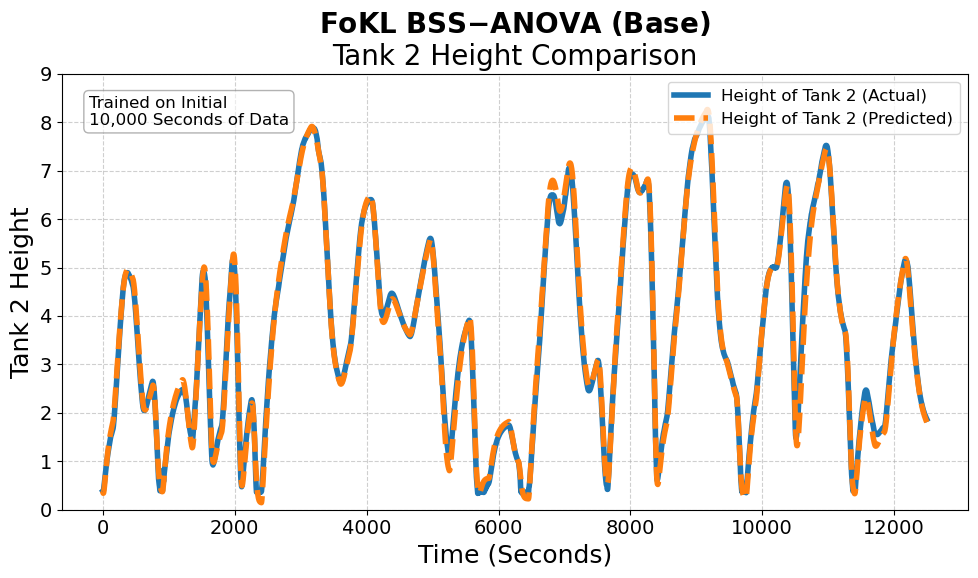

In [5]:
# Plot with improved aesthetics
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase/decrease font size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both the actual and predicted data
ax.plot(df['time'], df['h2'], label='h1', linewidth=4, linestyle='-')#, color='blue')
ax.plot(df['time'], df['h2_prediction'], label='h2_prediction', linewidth=4, linestyle='--')#, color='red')

# Enhancing the graph with titles, labels, and grid
ax.set_title(r'$\bf{FoKL\ BSS{-}ANOVA\ (Base)}$' + '\nTank 2 Height Comparison', fontsize=20)
ax.set_xlabel('Time (Seconds)', fontsize=18)
ax.set_ylabel('Tank 2 Height', fontsize=18)
ax.legend(['Height of Tank 2 (Actual)', 'Height of Tank 2 (Predicted)'], fontsize=12, loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)

# ax.text(-250, 7, 'Trained on Initial \n10,000 Seconds of Data', fontsize=12, color='black', bbox = dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha = 0.6))

# Add a note in the upper-left corner with a rounded box
ax.text(0.03, 0.95, 'Trained on Initial \n10,000 Seconds of Data',
        fontsize=12, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha = 0.6),
        transform=ax.transAxes,  # Use normalized coordinates
        verticalalignment='top',  # Align text to the top of the box
        horizontalalignment='left')  # Align text to the left

ax.set_ylim(0, 9)

# Show plot
plt.tight_layout()
plt.show()